In [291]:
import time
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import networkx as nx
# import xarray as xr
import seaborn as sns 
# from scipy.special import expit, logit
import scipy as sp
from itertools import combinations

import os


import jax
import jax.numpy as jnp
from jax import random, jit
from jax.scipy.special import expit, logsumexp
from functools import partial
import numpyro.distributions as dist 
import numpyro
from numpyro.contrib.funsor import config_enumerate
from numpyro.util import set_host_device_count
from numpyro.contrib.control_flow import scan
from numpyro.ops.indexing import Vindex
from tqdm import tqdm
from joblib import Parallel, delayed

from numpyro import handlers
from numpyro.infer import MCMC, HMC, NUTS, DiscreteHMCGibbs, MixedHMC, Predictive
import pyro
import pymc_experimental as pmx

import multiprocessing
import socket

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on PyMC-experimental v{pmx.__version__}")
print(f"Running on NumPyro v{numpyro.__version__}")
print(f"Running on Pyro v{pyro.__version__}")
print(f"Running on JAX v{jax.__version__}")


Running on PyMC v5.10.4
Running on PyMC-experimental v0.0.17
Running on NumPyro v0.14.0
Running on Pyro v1.9.0+f02dfb9
Running on JAX v0.4.25


In [2]:
# Set CPU for JAX
# nchains = multiprocessing.cpu_count()/2
# print("nchains in total are", nchains*2, "; we'll use ", nchains)


# jax.config.update('jax_platform_name', 'cpu')
# platform = jax.lib.xla_bridge.get_backend().platform.casefold()
# print("Platform: ", platform)
# host_name = socket.gethostname()
# localhost_ = socket.gethostbyname(host_name)
# print(localhost_)

# jax.distributed.initialize(coordinator_address="localhost", num_processes=4, process_id=1)
# print(jax.device_count())
# print(jax.local_device_count())

# set_host_device_count(nchains)
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
print(jax.devices('cpu'))




[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]


In [3]:
RANDOM_SEED = 892357143
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-white")

(array([1.3341e+04, 1.1513e+04, 8.6060e+03, 5.6440e+03, 3.2020e+03,
        1.5890e+03, 6.4500e+02, 2.4000e+02, 6.4000e+01, 6.0000e+00]),
 array([4.29458077e-05, 1.68656179e+00, 3.37308064e+00, 5.05959948e+00,
        6.74611833e+00, 8.43263718e+00, 1.01191560e+01, 1.18056749e+01,
        1.34921937e+01, 1.51787126e+01, 1.68652314e+01]),
 <BarContainer object of 10 artists>)

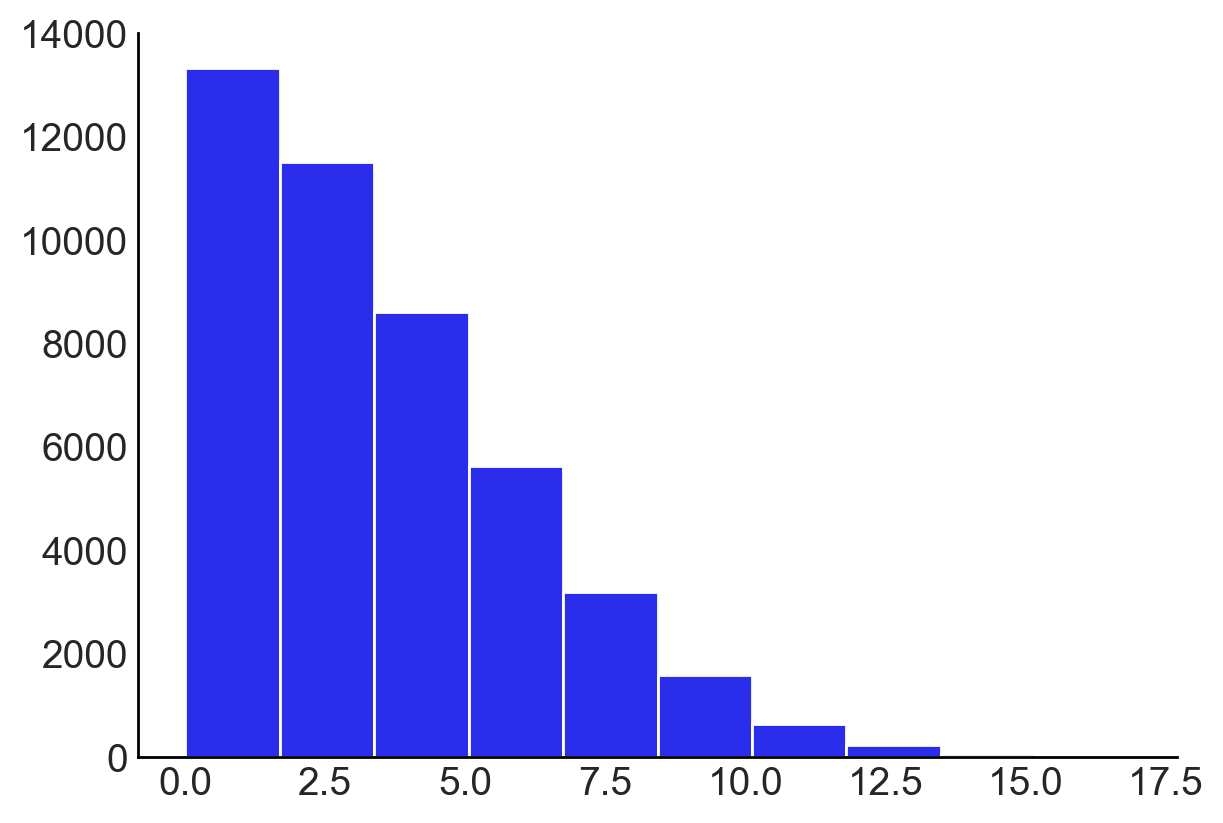

In [150]:
n=300
tril_dim = int(n*(n-1)/2)  
# x = rng.integers(low=0,high=1,size=n,endpoint=True)
x = rng.normal(loc=0,scale=3,size=n)
# x = rng.uniform(size=n,low=-3,high=3)
# x = rng.standard_t(size=n,df=5)
# x2 = rng.binomial(n=1,p=0.25,size=n)

# x_diff = []
# # x2_equal =[]
# for i in range(n):
#     for j in range(i+1,n):
#         x_diff.append(np.abs(x[i]-x[j]))
#         # x2_equal.append(x2[i]==x2[j])
# x_diff = np.array(x_diff)
# x2_equal = np.array(x2_equal)
# plt.hist(x_diff)
# Create probs
# beta = -3, -.5,2 
# beta = -2, -.5

idx_pairs = combinations(range(len(x)),2)
x_diff = np.array([abs(x[i] - x[j]) for i, j in idx_pairs])


plt.figure(figsize=(5,3))
plt.hist(x_diff)


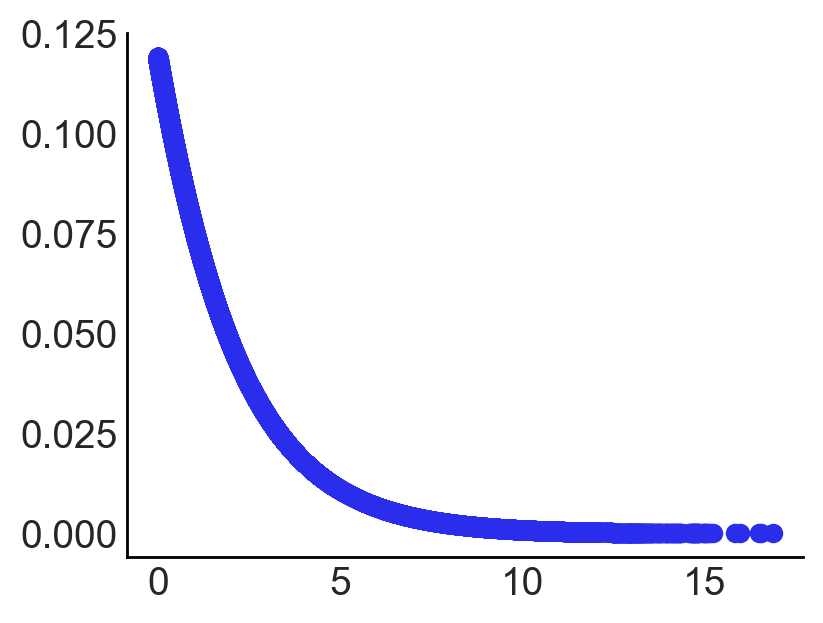

In [163]:
beta = -2, -0.5
# probs = expit(beta[0] + beta[1]*x_diff + rng.normal(-.5,1,tril_dim))
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
probs = expit(beta[0] + beta[1]*x_diff)

plt.figure(figsize=(4,3))
plt.scatter(x_diff,probs)

# Generate adj. matrix
mat = np.zeros((n,n))
# idx_lt = np.tril_indices(n=n,k=-1)
idx_ut = np.triu_indices(n=n,k=1)
# edges = rng.binomial(n=1,p=0.5,size=tril_dim)
edges = rng.binomial(n=1,p=probs,size=tril_dim)

mat[idx_ut] = edges
# mat[idx_lt] = edges
mat = mat + mat.T
triu_vals = mat[np.triu_indices(n,k=1)]




In [302]:
sparse_mat = sp.sparse.csr_matrix(mat)
_, eigenvector = sp.sparse.linalg.eigs(sparse_mat, k=1, which = 'LR')

#  _, eigenvector = sp.sparse.linalg.eigs(
#         M.T, k=1, which="LR", maxiter=max_iter, tol=tol
#     )
largest = eigenvector.flatten().real
# print(largest)
print(np.sign(largest.sum()))
print(sp.linalg.norm(largest))
norm = np.sign(largest.sum()) * sp.linalg.norm(largest)
manual_eig_center = largest / norm

1.0
0.9999999999999997


In [301]:
mat_net = nx.from_numpy_array(mat)

degrees = np.array([degree for _, degree in mat_net.degree()])
deg_center = np.array(list(nx.degree_centrality(mat_net).values()))
eigen_center = np.array(list(nx.eigenvector_centrality_numpy(mat_net).values()))
closeness = np.array(list(nx.closeness_centrality(mat_net).values()))
betweeness = np.array(list(nx.betweenness_centrality(mat_net).values()))
# flow_betweeness = np.array(list(nx.current_flow_betweenness_centrality(mat_net).values()))
# flow_betweeness = np.array(list(nx.approximate_current_flow_betweenness_centrality(mat_net,epsilon=0.1).values()))
triangles = np.array(list(nx.triangles(mat_net).values()))
clustering = np.array(list(nx.clustering(mat_net).values()))


True

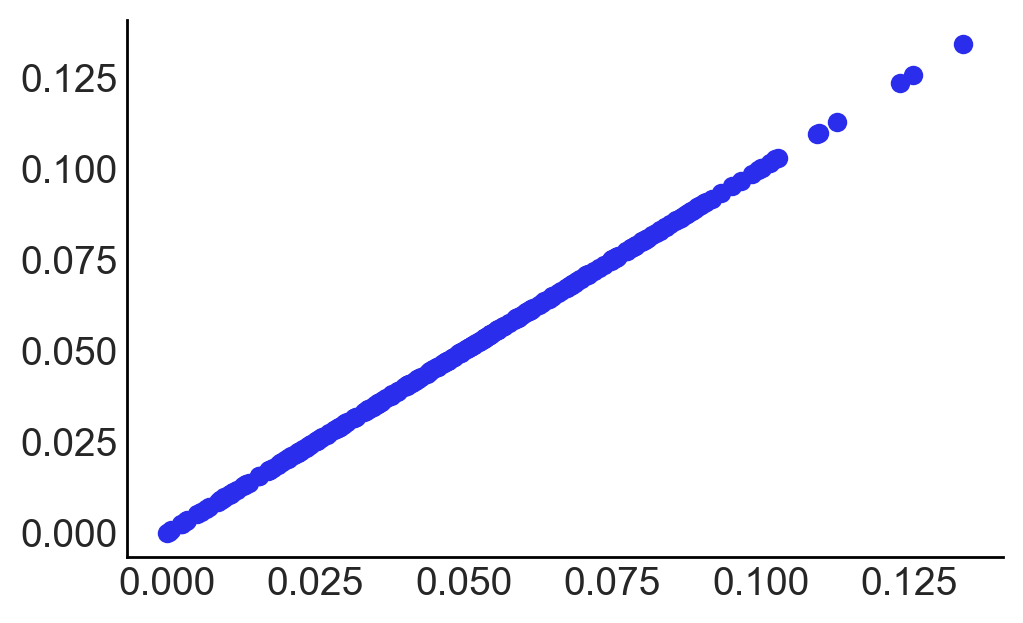

In [297]:
plt.figure(figsize=(5,3))
# np.array(list(eigen_center)).shape
# plt.hist(degrees)
# plt.hist(triangles)
# plt.hist(clustering)
# plt.hist(closeness)
# plt.hist(flow_betweeness)
# plt.hist(betweeness)
# plt.hist(closeness*triangles)
# plt.scatter(deg_center,degrees)
# plt.scatter(degrees,closeness)
# plt.scatter(betweeness,closeness)
# plt.scatter(betweeness,flow_betweeness)
# plt.scatter(triangles,flow_betweeness)
# plt.scatter(app_flow_betweeness,flow_betweeness)
# plt.scatter(triangles,closeness)
# plt.scatter(triangles,betweeness)
# plt.scatter(betweeness,degrees)
# plt.scatter(betweeness,triangles)
# plt.scatter(triangles,degrees)
# plt.scatter(triangles,betweeness)
# plt.scatter(triangles,eigen_center)
plt.scatter(manual_eig_center,eigen_center)

In [206]:
print(min(betweeness),max(betweeness))
print(min(eigen_center),max(eigen_center))
print(min(triangles),max(triangles))


0.0 0.023252218309697967
-4.610495665055091e-18 0.13419230403113389
0 22


In [174]:
np.dot(np.transpose(np.array([[1]*n,x])),[2,3])

array([ 9.84113989e+00, -2.61899315e+00, -6.03811694e+00,  1.36374062e+01,
        5.91632139e+00,  2.48010613e+01,  6.24770691e+00,  7.33447753e+00,
        5.84140722e+00, -2.03361713e+01,  4.19854892e+00, -3.18128119e-01,
       -3.21228408e+00, -3.02971458e+00,  2.21485293e+01,  9.46562857e+00,
       -6.12503042e+00, -5.34298063e-01,  1.35683160e+01, -3.75083736e+00,
       -5.44941886e+00,  3.07131028e+00, -3.10174083e+00,  2.15155238e+00,
        5.01503961e-01, -1.38576464e+01,  1.17107191e+01,  1.56613973e+01,
        5.53205130e+00, -1.39523656e+01,  5.10998085e+00, -2.09762192e+00,
        1.68682897e+00,  1.03735028e+01,  2.59229260e+00,  6.08121256e+00,
        6.78767808e+00,  7.93350445e+00, -4.37845044e+00, -1.79236660e+00,
        4.00264539e+00, -1.30416452e+01,  6.62607735e+00, -1.16549565e+01,
       -1.08771262e+01,  6.71026422e+00,  5.53146616e+00, -2.95248870e+00,
        9.69275808e+00,  6.07179849e+00, -3.95452308e+00, -1.25273264e+01,
       -7.60276426e+00,  

                0
count  300.000000
mean     3.440000
std      2.057631
min      0.000000
25%      2.000000
50%      3.000000
75%      5.000000
max     10.000000
                0
count  299.000000
mean    -0.091152
std      1.996344
min     -7.984542
25%     -1.470969
50%     -0.108523
75%      1.143053
max      5.960947
                0
count  300.000000
mean    -0.111210
std      3.124540
min     -9.264878
25%     -1.993826
50%     -0.058421
75%      1.896184
max      7.600354


C:\Users\bar21\AppData\Local\Temp\ipykernel_9508\1397781342.py:6: RuntimeWarning: invalid value encountered in divide
  x_neighbors = np.dot(mat,x) / degrees


(array([ 2., 15., 29., 47., 63., 61., 38., 28.,  7., 10.]),
 array([-4.56743977, -3.27358992, -1.97974008, -0.68589023,  0.60795961,
         1.90180945,  3.1956593 ,  4.48950914,  5.78335899,  7.07720883,
         8.37105868]),
 <BarContainer object of 10 artists>)

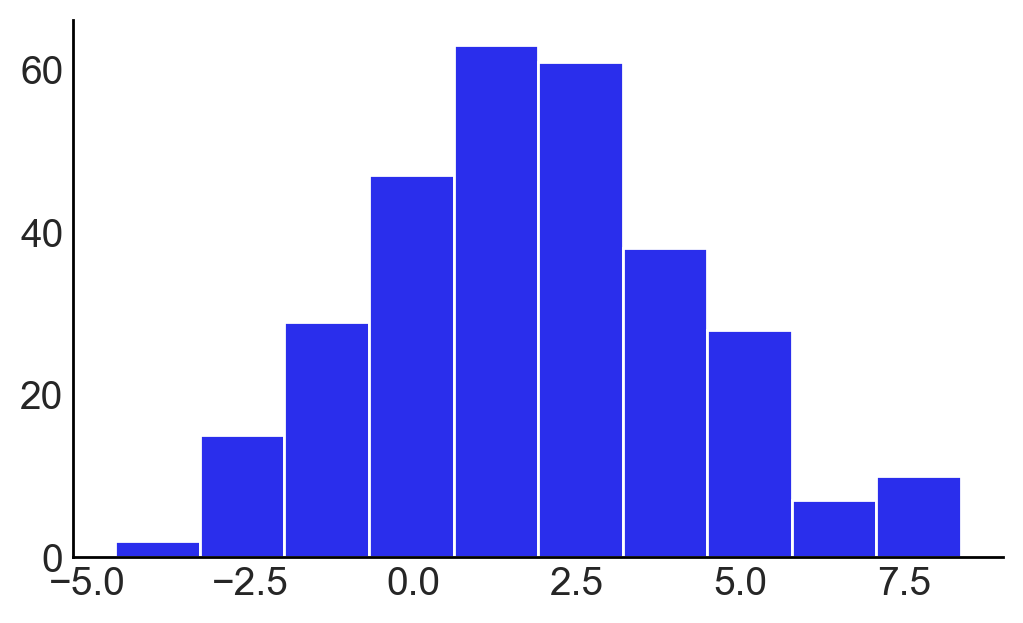

In [207]:
# Create outcome data

Z = rng.binomial(n=1,p=0.3,size=n)
exposures = np.dot(mat,Z) 
print(pd.DataFrame(exposures).describe())
x_neighbors = np.dot(mat,x) / degrees
print(pd.DataFrame(x_neighbors).describe())
print(pd.DataFrame(x).describe())

# expos_binary = exposures > 0.5
# print(np.mean(expos_binary))
# alpha = -.5, 2, 1, -1
# alpha = -1, 3, 1, 0.5, -0.25
# alpha = -.5, 2, .5, 0.25, -0.25
# alpha = -.5, 2, 0.5, -0.25, -0.25
# alpha = -2, 3, 1, -.5
alpha = -1, 3, 0.5, -.25, 5, 5 

df_array = np.transpose(np.array([[1]*n,Z,exposures,x,eigen_center,betweeness]))
mean_y = np.dot(df_array,alpha)
# Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*x + alpha[4] + rng.normal(loc=0,scale=1,size=n)
Y = mean_y + rng.normal(loc=0,scale=1,size=n)

plt.figure(figsize=(5,3))
plt.hist(Y)


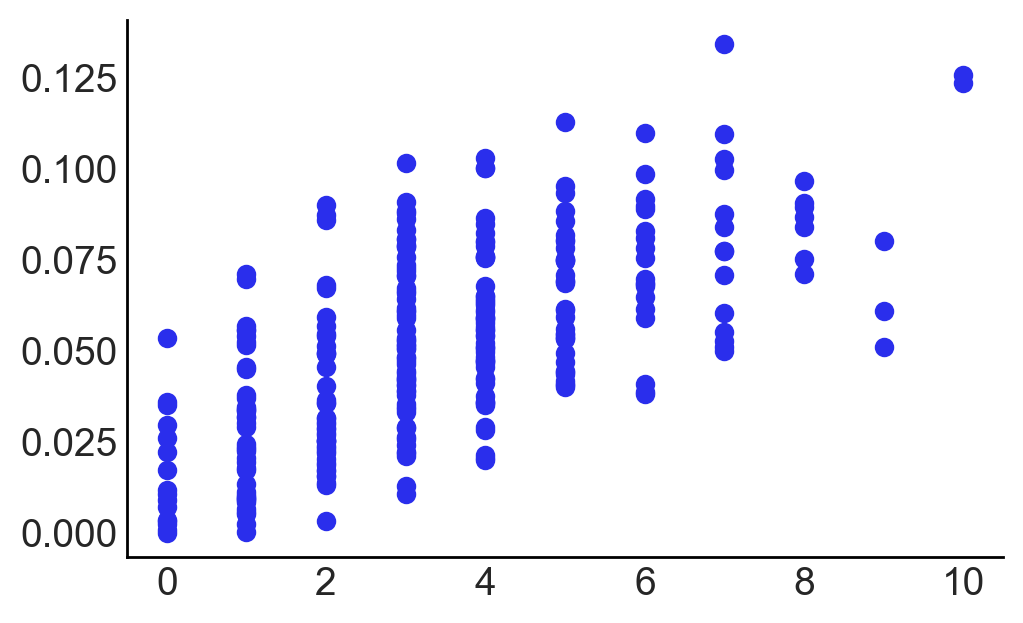

In [208]:
plt.figure(figsize=(5,3))
# plt.scatter(exposures,betweeness)
plt.scatter(exposures,eigen_center)
# plt.scatter(betweeness,eigen_center)

In [7]:
# DG = nx.from_numpy_array(mat)
# nx.set_node_attributes(DG, Z, "Treatments") 
# nx.draw(DG, with_labels=True,  node_color = Z)
# plt.legend()
# plt.show()

In [181]:
# Create noisy measurement of `mat`
# gamma1 = 0.25  # Remove existing edge with prob `alph`
gamma1 = 0.25  # Remove existing edge with prob `alph`
# gamma0 = gamma1/5 # add non-existing edge with prob `bet` 
gamma0 = 0.05 # add non-existing edge with prob `bet` 

obs_mat = np.zeros((n,n)) # create nXn matrix of zeros
# obs_mat[np.tril_indices(n=n,k=-1)] = tril_vals # init as true network
obs_mat[np.triu_indices(n=n,k=1)] = triu_vals # init as true network
for i in range(0,n): # add noise
    for j in range(i+1,n):
        if mat[i,j] == 1:
            obs_mat[i,j] = rng.binomial(n=1,p=1-gamma1,size=1)[0] # retain existing edge w.p. `1-gamma1`
        else:
            obs_mat[i,j] = rng.binomial(n=1,p=gamma0,size=1)[0] # add non-existing edge w.p. `gamma0` 
            
obs_mat = obs_mat + obs_mat.T
triu_obs = obs_mat[np.triu_indices(n=n,k=1)]
# tril_obs = obs_mat[np.tril_indices(n=n,k=-1)]


(array([ 6., 23., 23., 58., 44., 65., 42., 20., 13.,  6.]),
 array([11. , 13.6, 16.2, 18.8, 21.4, 24. , 26.6, 29.2, 31.8, 34.4, 37. ]),
 <BarContainer object of 10 artists>)

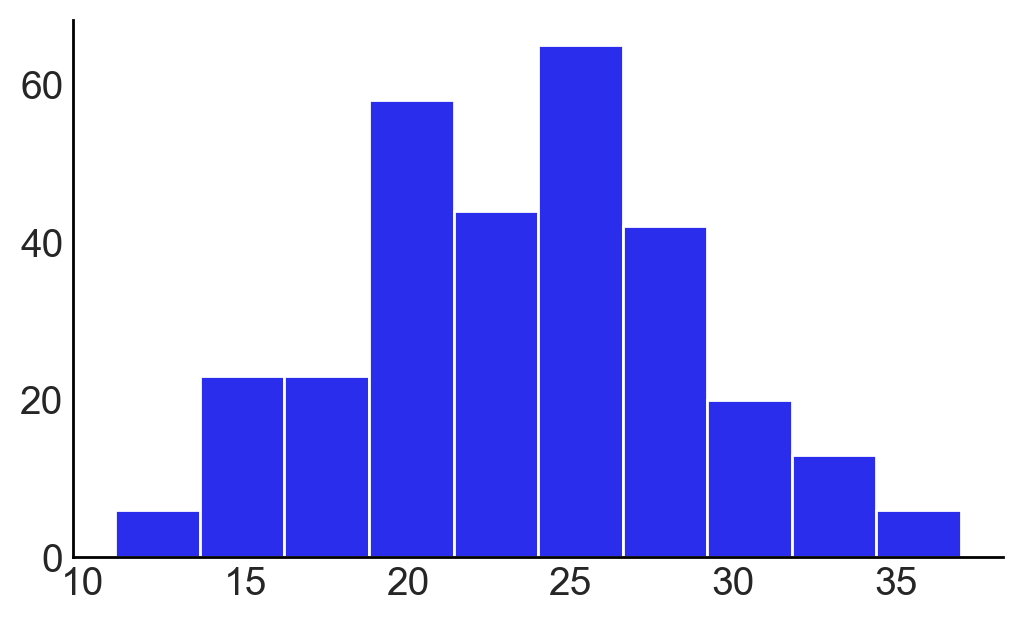

In [182]:
# Plot noisy observed network 
# DG_noise = nx.from_numpy_array(obs_mat)
# nx.draw(DG_noise, with_labels=True,  node_color = Z)
# plt.show()
plt.figure(figsize=(5,3))
plt.hist(np.sum(obs_mat,1))

In [183]:
trils_pd = pd.DataFrame({'true' : triu_vals, 'obs' : triu_obs})
pd.crosstab(index=trils_pd['true'], columns=trils_pd['obs'])


obs,0.0,1.0
true,,
0.0,40889,2191
1.0,447,1323


                0
count  300.000000
mean     6.916667
std      2.650750
min      1.000000
25%      5.000000
50%      7.000000
75%      9.000000
max     16.000000
Corr obs~true exposures:  0.5334720970305386


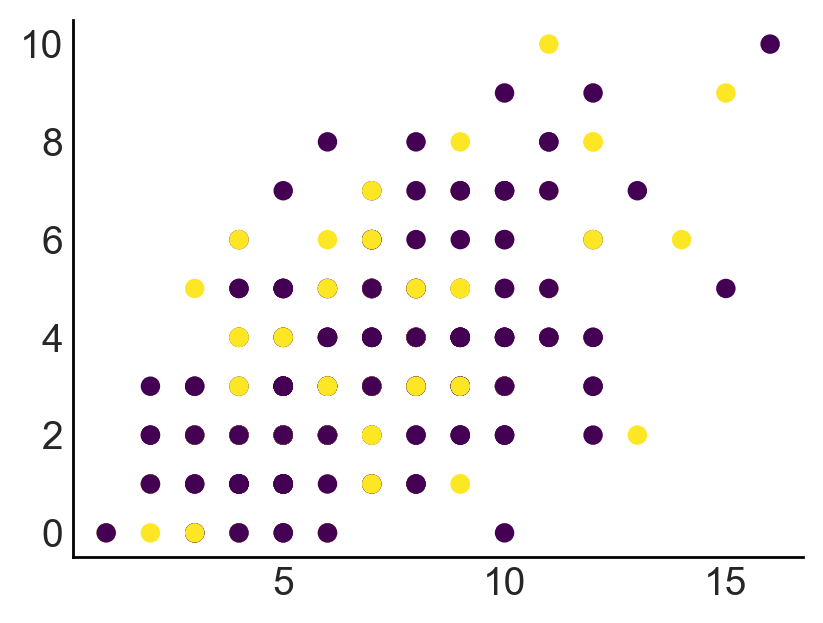

In [209]:

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1) > 0.5
# # obs_exposures = np.dot(obs_mat,Z)
# obs_exposures = np.dot(obs_mat,Z)

obs_net = nx.from_numpy_array(obs_mat)
obs_deg = np.array([degree for _, degree in obs_net.degree()])
obs_betweeness = np.array(list(nx.betweenness_centrality(obs_net).values()))
# obs_triangles = np.array(list(nx.triangles(obs_net).values()))
obs_eigen_center = np.array(list(nx.eigenvector_centrality_numpy(obs_net).values()))
obs_exposures = np.dot(obs_mat,Z)

obs_df = np.transpose(np.array([[1]*n, Z, obs_exposures,x, obs_eigen_center, obs_betweeness]))

print(pd.DataFrame(obs_exposures).describe())

print("Corr obs~true exposures: ", np.corrcoef(exposures, obs_exposures)[1,0])

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1)
# expos_pd = pd.DataFrame({'true' : exposures, 'obs' : obs_exposures})
# pd.crosstab(index=expos_pd['true'], columns=expos_pd['obs'])
plt.figure(figsize=(4,3))
plt.scatter(obs_exposures,exposures, c=Z)

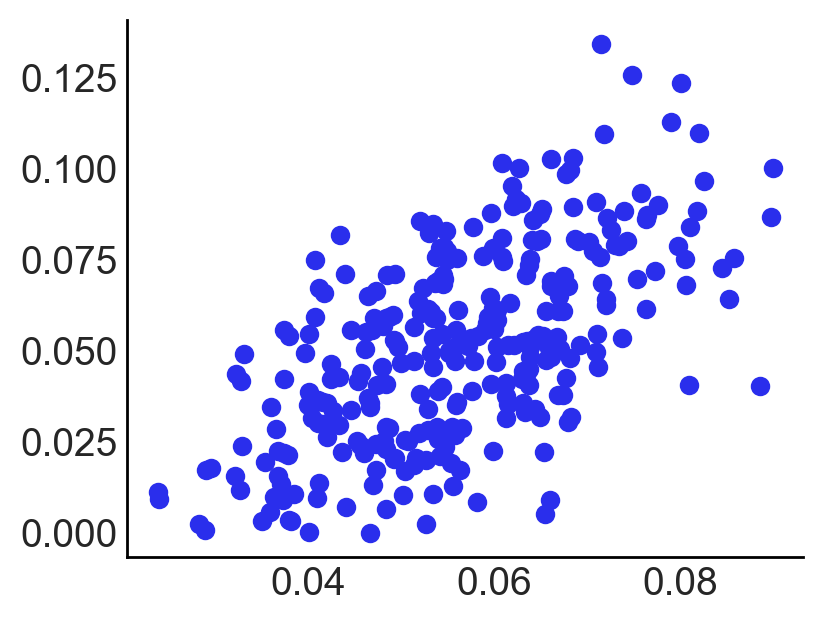

In [210]:
plt.figure(figsize=(4,3))
# plt.scatter(obs_betweeness, betweeness)
plt.scatter(obs_eigen_center, eigen_center)

In [12]:
# with pm.Model() as model_obs_mat:
#       # Data
#     x = pm.ConstantData("x_d", x_diff)
#     z = pm.ConstantData("Z",Z)
#     # obs_tril = pm.ConstantData("obs_tril", tril_obs)
#     obs_triu = pm.ConstantData("obs_triu", triu_obs)
#     expos = pm.ConstantData("expos", obs_exposures)
#     y = pm.ConstantData("Y_",Y)
#     
#     # Define priors
#     beta0 = pm.Normal("beta0",mu=0, sigma=10)
#     beta1 = pm.Normal("beta1",mu=0, sigma=10)
#     # u = pm.Normal("U",mu=0,sigma=10)
#   
#     # network prior model
#     mu = beta0 + beta1*x 
#     prob = pm.math.invlogit(mu)
#     triu = pm.Bernoulli("triu", p=prob, observed=obs_triu)
#     # tril = pm.Bernoulli("tril", p=prob, observed=obs_tril)
#     # Ltri_A_mat = pm.Bernoulli("tril", p=prob, observed = obs_tril)
#     
#     # Outcome model
#     alpha0 = pm.Normal("alpha0",mu=0,sigma=10)
#     alpha1 = pm.Normal("alpha1",mu=0,sigma=10)    
#     alpha2 = pm.Normal("alpha2",mu=0,sigma=10)
#     alpha3 = pm.Normal("alpha3",mu=0,sigma=10)
#     sig_y = pm.HalfNormal("sig_y",sigma=5)
#     # mu_y = alpha0 + alpha1*z + alpha2*expos 
#     mu_y = alpha0 + alpha1*z + alpha2*expos +  alpha3*z*expos 
#     Outcome = pm.Normal("Outcome",mu=mu_y,sigma=sig_y,observed=y)
#       
# pm.model_to_graphviz(model_obs_mat)

In [13]:
# def triu_vals_to_mat(triu_vals, n):
#     # Z_val = Z.eval()
#     triu_vals_ = triu_vals.eval()
#     AM = np.zeros((n,n))
#     AM[np.triu_indices(n=n,k=1)] = triu_vals_
#     # AM[np.tril_indices(n=n,k=-1)] = tril_vals_
#     # AM = AM + AM.T 
#     return AM + AM.T 
#     # return np.dot(AM,Z_val)/np.sum(AM,1)
#     
# # def get_network_miss_prob(tril_vals, gamma0, gamma1):
# #     tril_vals = tril_vals.eval()
# #     obs_tril_prob = 
# 
# with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
#     
#     # Data
#     x = pm.ConstantData("x_d", x_diff)
#     z = pm.ConstantData("Z",Z)
#     triu_data = pm.ConstantData("triu_data", triu_obs)
#     y = pm.ConstantData("Y_",Y)
#     
#     # Define priors
#     beta0 = pm.Normal("beta0",mu=0, sigma=10)
#     beta1 = pm.Normal("beta1",mu=0, sigma=10)
#     # u = pm.Normal("U",mu=0,sigma=10)
#   
#     # network prior model
#     mu = beta0 + beta1*x 
#     prob = pm.math.invlogit(mu)
#     triu = pm.Bernoulli("triu", p=prob)
#     # Ltri_A_mat = pm.Bernoulli("tril", p=prob, observed = obs_tril)
#     
#   
#     # network misspecifcation model
#     Gamma0 = pm.Uniform("Gamma0", lower=0,upper=.5)
#     Gamma1 = pm.Uniform("Gamma1",lower=0,upper=.5)
#     prob_misspec = triu*(1-Gamma1) + (1-triu)*Gamma0
#     obs_triu = pm.Bernoulli("obs_triu", p = prob_misspec, observed = triu_data)
#     
#     # Generate net stats
#     A_mat = triu_vals_to_mat(triu,n)
#     expos = pm.Deterministic("expos", pm.math.dot(A_mat,z))
#     deg = pm.Deterministic("deg", pm.math.sum(A_mat,1))
#     
#     # Outcome model
#     alpha0 = pm.Normal("alpha0",mu=0,sigma=5)
#     alpha1 = pm.Normal("alpha1",mu=0,sigma=5)    
#     alpha2 = pm.Normal("alpha2",mu=0,sigma=5)
#     alpha3 = pm.Normal("alpha3",mu=0,sigma=5)
#     sig_y = pm.Exponential("sig_y",lam=.5)
#     mu_y = alpha0 + alpha1*z + alpha2*expos + alpha3*deg
#     Outcome = pm.Normal("Outcome",mu=mu_y,sigma=sig_y,observed=y)
#     
# pm.model_to_graphviz(model)    

In [14]:
# with model:
#     step1 = pm.Metropolis([beta0, beta1, Gamma0, Gamma1, alpha0, alpha1, alpha2, alpha3, sig_y])
#     step2 = pm.BinaryMetropolis([triu])
#     MH_step = pm.CompoundStep([step2, step1])
#     trace = pm.sample(draws=5000, tune=3000, chains=4, cores=4, step=MH_step)
#     # trace = pm.sample(draws=4000, tune=2000, chains=4, cores=4)
#     

In [15]:
# az.summary(trace)

In [16]:
# az.plot_trace(trace)


In [17]:
# with pmx.MarginalModel() as marg_model:      
#     # Data
#     x = pm.ConstantData("x_d", x_diff)
#     # z = pm.ConstantData("Z",Z)
#     triu_data = pm.ConstantData("triu_data", triu_obs)
#     # y = pm.ConstantData("Y_",Y)
#     # Define priors
#     beta0 = pm.Normal("beta0",mu=0, sigma=10)
#     beta1 = pm.Normal("beta1",mu=0, sigma=10)
#     # u = pm.Normal("U",mu=0,sigma=10)  
#     # network prior model
#     mu = beta0 + beta1*x 
#     prob = pm.math.invlogit(mu)
#     triu = pm.Bernoulli("triu", p=prob)
#     # Ltri_A_mat = pm.Bernoulli("tril", p=prob, observed = obs_tril)   
#   
#     # network misspecifcation model
#     Gamma0 = pm.Uniform("Gamma0", lower=0,upper=.5)
#     Gamma1 = pm.Uniform("Gamma1",lower=0,upper=.5)
#     prob_misspec = triu*(1-Gamma1) + (1-triu)*Gamma0
#     pm.Bernoulli("obs_triu", p = prob_misspec, observed = triu_data)    
#     # logit model of edges
#     # mu = beta0 + beta1*x + u 
#     # prob = pm.math.invlogit(mu)
#     # Ltri_A_mat = pm.Bernoulli("
#     
#     # Get exposures
#     # expos = tril_vals_to_exposures(obs_tril, z, n)
#     # Lower tri to adj. matrix
#     # A_mat = tril_vals_to_mat(obs_tril,n)
#     # A_mat = triu_vals_to_mat(triu,n)
#     # degress = pm.math.sum(A_mat,1)
#     # sum_expos = pm.math.dot(A_mat,z)
#     # expos = pm.Deterministic("expos", pm.math.switch(pt.tensor.eq(degress,0),0,sum_expos/degress))
#     # # expos = pm.Deterministic("expos", pm.math.dot(A_mat,z)/pm.math.sum(A_mat,1))
#     # # expos = pm.Deterministic("expos", pm.math.dot(A_mat,z))
#     # # Outcome model
#     # alpha0 = pm.Normal("alpha0",mu=0,sigma=10)
#     # alpha1 = pm.Normal("alpha1",mu=0,sigma=10)    
#     # alpha2 = pm.Normal("alpha2",mu=0,sigma=10)
#     # alpha3 = pm.Normal("alpha3",mu=0,sigma=10)
#     # # alpha3 = pm.Normal("alpha3",mu=0,sigma=5)
#     # sig_y = pm.HalfNormal("sig_y",sigma=5)
#     # # mu_y = alpha0 + alpha1*z + alpha2*expos + alpha3*(expos**2)
#     # # mu_y = alpha0 + alpha1*z + alpha2*expos 
#     # mu_y = alpha0 + alpha1*z + alpha2*expos + alpha3*z*expos 
#     # Outcome = pm.Normal("Outcome",mu=mu_y,sigma=sig_y,observed=y)
#     
# marg_model.marginalize(["triu"])
# pm.model_to_graphviz(marg_model)    

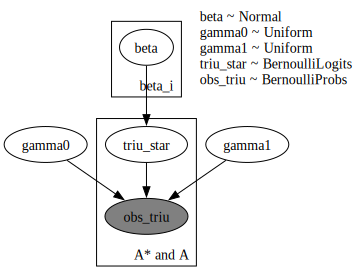

In [194]:
# NumPyro model
def triu_to_mat(triu, n):
    adj_mat = jnp.zeros((n,n))
    idx_utri = np.triu_indices(n=n,k=1)
    adj_mat = adj_mat.at[idx_utri].set(triu) 
    return adj_mat + adj_mat.T

@config_enumerate
def network_model(X, TriU, n):
    # Network model
    # beta_0 = numpyro.sample("beta0",dist.Normal(0,10))
    # beta_1 = numpyro.sample("beta1",dist.Normal(0,10))
    with numpyro.plate("beta_i",2):
        beta = numpyro.sample("beta", dist.Normal(0,10))
    mu_net = beta[0] + beta[1]*X 
    triu_n = int(n*(n-1)/2)
    
    gamma0 = numpyro.sample("gamma0", dist.Uniform(low=0,high=0.5))
    gamma1 = numpyro.sample("gamma1", dist.Uniform(low=0,high=0.5))
    # gamma0 = numpyro.sample("gamma0", dist.Beta(2,5))
    # gamma1 = numpyro.sample("gamma1", dist.Beta(2,5))
    
    with numpyro.plate("A* and A", triu_n):
        triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_net),
                                   infer={"enumerate": "parallel"})
        # prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
        prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*gamma0
        numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
        
    # def triu_fn(carry, inp):
    #     # print("Starting tril_fn carry no.", carry)
    #     # mu_n = inp
    #     mu_n, triu_val = inp
    #     # logp of A* 
    #     # with numpyro.plate("Edges A*", triu_n):
    #     triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_n),
    #                                infer={"enumerate": "parallel"})
    #     # print("Triu_Star shape (within) is", triu_star.shape)
    #     # # logp of A|A*
    #     # # with numpyro.plate("A|A*", 1):
    #     prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
    #     # print("prob_misspec shape is: ", prob_misspec.shape)
    #     # obs_triu_vals = numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
    #     return carry+1, triu_star  
    # 
    # sc_input = jnp.array((mu_net, TriU)).T
    # _, triu_var = scan(triu_fn, jnp.array(0), sc_input)
    # print("triu_var shape is: ", triu_var.shape)
    # scan(triu_fn, jnp.array(0), sc_input)    
    # 


# def outcome_model(Y,Z,X,A,n):
def outcome_model(Y,X):
    with numpyro.plate("alpha_i",X.shape[1]):
        alpha = numpyro.sample("alpha",dist.Normal(0,10))
    # sig = numpyro.sample("sig",dist.HalfNormal(scale=5))
    sig = numpyro.sample("sig",dist.Exponential(0.5))
    
    # expos = jnp.dot(A,Z)
    # expos = (jnp.dot(A,Z) / jnp.sum(A,1)) > 0.5
    # sum_expos = jnp.dot(A,Z)
    # deg = jnp.sum(A,1)
    # expos = jnp.where(jnp.equal(deg,0), 0, sum_expos/deg)
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*X 
    mu_y = jnp.dot(X, alpha)
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*deg  + alpha[4]*X
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    with numpyro.plate("n",n):
        numpyro.sample("Y", dist.Normal(loc=mu_y,scale=sig), obs=Y)

# numpyro.render_model(model, model_args=(Y,Z,x_diff,triu_obs,n), render_distributions=True)
numpyro.render_model(network_model, model_args=(x_diff,triu_obs,n), render_distributions=True)
# numpyro.render_model(model, model_args=(Y,Z,x_diff,tril_vals))
# TODO: Check different samplers in NumPyro (e.g., HMCwithGibbs, M-HMC, marginalization); They are probably slow, check their runtime and ESS (e.g., in comparison to PyMC).
# TODO: Replace `for` loop with `enumerate`; use `scan` function (see NumPyro HMM guide https://num.pyro.ai/en/stable/examples/hmm_enum.html) see also https://pyro.ai/examples/enumeration.html
# TODO: see also this numpyro guidebook (``rethinking") https://fehiepsi.github.io/rethinking-numpyro/

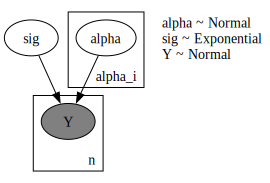

In [195]:
# numpyro.render_model(outcome_model, model_args=(Y,Z,x,mat,n), render_distributions=True)
numpyro.render_model(outcome_model, model_args=(Y,df_array), render_distributions=True)

In [196]:
# A* and A|A* models

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model))
# kernel = MixedHMC(HMC(model, trajectory_length=1.2))
# kernel = NUTS(model, dense_mass=True)
kernel_network = NUTS(network_model)
mcmc_network = MCMC(kernel_network, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
mcmc_network.run(rng_key_,X=x_diff,TriU=triu_obs,n=n)
mcmc_network.print_summary()
samples_network = mcmc_network.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     -2.00      0.25     -2.03     -2.38     -1.60   5015.63      1.00
   beta[1]     -0.51      0.08     -0.50     -0.63     -0.38   5955.82      1.00
    gamma0      0.05      0.00      0.05      0.05      0.06   6145.54      1.00
    gamma1      0.25      0.14      0.25      0.03      0.48   5044.69      1.00

Number of divergences: 0
337.79762601852417


In [211]:
# Outcome model with A* (true network)

start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_true = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=100, num_samples=10,num_chains=1)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,A=obs_mat,n=n)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,X=x,A=mat,n=n)
mcmc_network_true.run(rng_key_,Y=Y,X=df_array)
mcmc_network_true.print_summary()
samples_net_true = mcmc_network_true.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -1.41      0.14     -1.41     -1.65     -1.18  13217.97      1.00
  alpha[1]      2.98      0.14      2.98      2.75      3.20  17074.06      1.00
  alpha[2]      0.56      0.04      0.56      0.49      0.62  12666.98      1.00
  alpha[3]     -0.26      0.02     -0.26     -0.29     -0.22  17581.85      1.00
  alpha[4]      9.61      3.11      9.63      4.46     14.68  10070.26      1.00
  alpha[5]      3.70      9.31      3.72    -11.58     18.87  17974.33      1.00
       sig      1.07      0.04      1.07      1.00      1.15  18492.43      1.00

Number of divergences: 0
6.093512296676636


In [212]:
# Outcome model with A (observed network)

start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_obs = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,X=x,A=obs_mat,n=n)
mcmc_network_obs.run(rng_key_,Y=Y, X=obs_df)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_obs.print_summary()
samples_net_obs = mcmc_network_obs.get_samples()
print(time.time() - start)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -1.41      0.36     -1.41     -2.00     -0.82  10899.78      1.00
  alpha[1]      3.16      0.20      3.16      2.82      3.48  15711.16      1.00
  alpha[2]      0.20      0.04      0.20      0.14      0.27  13568.81      1.00
  alpha[3]     -0.26      0.03     -0.26     -0.31     -0.21  15448.54      1.00
  alpha[4]     17.11      6.47     17.17      6.99     28.24  10156.29      1.00
  alpha[5]      0.74     10.12      0.83    -15.73     17.30  16324.77      1.00
       sig      1.56      0.06      1.56      1.46      1.67  15858.29      1.00

Number of divergences: 0
6.196207284927368


In [213]:
print([f"beta_{i} = {bet}" for i,bet in enumerate(beta)], "gamma0:", gamma0, "gamma1:", gamma1)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)

['beta_0 = -2', 'beta_1 = -0.5'] gamma0: 0.05 gamma1: 0.25
['alpha_0 = -1', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25', 'alpha_4 = 5', 'alpha_5 = 5'] sig: 1


In [214]:
print(samples_network["beta"].shape)
print(samples_network["gamma0"].shape)
post_pred_mean = {"beta" : jnp.expand_dims(jnp.mean(samples_network["beta"],axis=0),-2),
                  "gamma0" : jnp.expand_dims(jnp.mean(samples_network["gamma0"]),-1),
                  "gamma1" : jnp.expand_dims(jnp.mean(samples_network["gamma1"]),-1)}
print(post_pred_mean)
a_star_pred = Predictive(model=network_model, posterior_samples=post_pred_mean, infer_discrete=True,num_samples=1)
# The following is how to sample multiple different A* with the mean posterior of A* and A|A* parameters
a_star_pred1 = a_star_pred(random.PRNGKey(0), X=x_diff,TriU=triu_obs,n=n)
a_star_pred2 = a_star_pred(random.PRNGKey(1), X=x_diff,TriU=triu_obs,n=n)
# print(a_star_pred)
# print(a_star_pred1["triu_star"])
print(a_star_pred1["triu_star"].shape)
print(a_star_pred2["triu_star"].shape)
print(jnp.array_equal(a_star_pred1["triu_star"],a_star_pred2["triu_star"]))

twoAst = pd.DataFrame({'first' : a_star_pred1["triu_star"][1], 'sec' : a_star_pred2["triu_star"][1]})
# print(twoAst)
pd.crosstab(index=twoAst['first'], columns=twoAst['sec'])

(16000, 2)
(16000,)
{'beta': Array([[-2.0010166 , -0.50693995]], dtype=float32), 'gamma0': Array([0.05158332], dtype=float32), 'gamma1': Array([0.2500318], dtype=float32)}
(1, 44850)
(1, 44850)
False


sec,0,1
first,,
0,41998,1153
1,1067,632


In [215]:
post_predictive = Predictive(network_model, samples_network, infer_discrete=True)
post_predictive = post_predictive(rng_key, X=x_diff,TriU=triu_obs,n=n)
samples_network["triu_star"] = post_predictive["triu_star"]
# print(post_predictive["triu_star"])
print(post_predictive["triu_star"].shape)
print(post_predictive["triu_star"][0,].shape)

(16000, 44850)
(44850,)


In [264]:
NN = n

@jax.jit
def Triu_to_mat(triu_v):
    adj_mat = jnp.zeros((NN,NN))
    # adj_mat = np.zeros((NN,NN))
    # obs_mat[np.triu_indices(n=NN,k=1)] = triu_v
    idx_utri = np.triu_indices(n=NN,k=1)
    adj_mat = adj_mat.at[np.triu_indices(n=NN,k=1)].set(triu_v) 
    return adj_mat + adj_mat.T

#     AM = np.zeros((NN,NN))
#     AM[np.triu_indices(n=NN,k=1)] = triu_v
#     return AM + AM.T 
# 
# 
# print(np.triu_indices(n=NN,k=1))
# print(a_star_pred1["triu_star"].shape)
# print(a_star_pred1["triu_star"][0])
# 
# st = time.time()
# for i in range(10000):
#     A1 = triu_to_mat(a_star_pred1["triu_star"], n)
# print("Regular takes: ", time.time() - st)

st = time.time()
for i in range(100):
    A2 = Triu_to_mat(a_star_pred1["triu_star"][i])
print("jax.jit takes: ", time.time() - st)

# np.array(Triu_to_mat(a_star_pred1["triu_star"][0])).shape

# print(np.array_equal(A1,A2))


jax.jit takes:  0.17292141914367676


(300, 300)
True expos~Y corr: 0.6059657359900121
Pred1 expos~Y corr: 0.2723033696794489
Pred2 expos~Y corr: 0.34109431351118774
obs expos~Y corr: 0.29609561306051313


Text(0, 0.5, 'True')

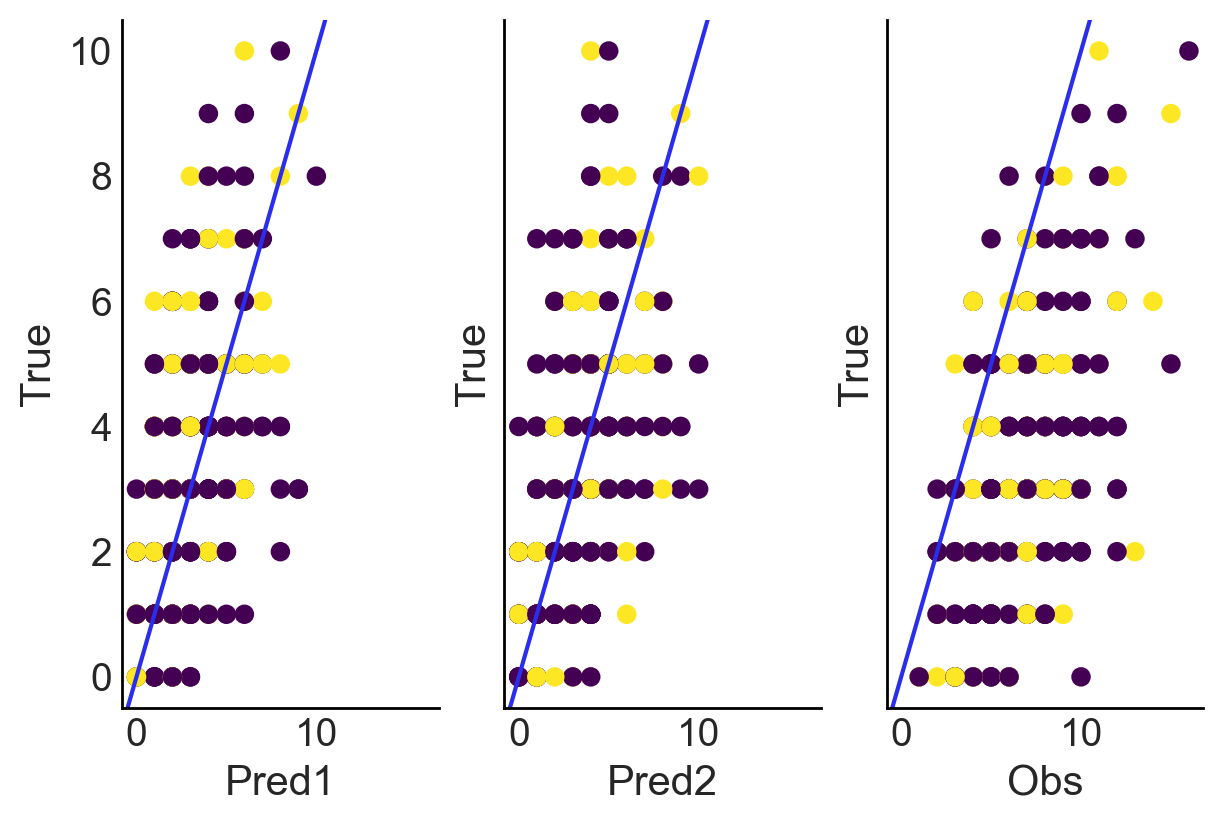

In [217]:

A_star_pred = Triu_to_mat(a_star_pred1["triu_star"][0])
A_star_pred2 = Triu_to_mat(a_star_pred2["triu_star"][0])
# A_star_pred = triu_to_mat(a_star_pred1["triu_star"],n)
# A_star_pred2 = triu_to_mat(a_star_pred2["triu_star"],n)
print(A_star_pred.shape)
# print(A_star_pred)


a_star_pred_deg = np.sum(A_star_pred,1)
a_star_pred_deg2 = np.sum(A_star_pred2,1)
a_star_sum_expos = np.dot(A_star_pred,Z) 
a_star_sum_expos2 = np.dot(A_star_pred2,Z)

Pred_expos1 = np.where(np.equal(a_star_pred_deg,0),0,a_star_sum_expos/a_star_pred_deg)
Pred_expos2 = np.where(np.equal(a_star_pred_deg2,0),0,a_star_sum_expos2/a_star_pred_deg2)

print("True expos~Y corr:",np.corrcoef(Y,exposures)[1,0])
print("Pred1 expos~Y corr:",np.corrcoef(Y,a_star_sum_expos)[1,0])
print("Pred2 expos~Y corr:",np.corrcoef(Y,a_star_sum_expos2)[1,0])
print("obs expos~Y corr:",np.corrcoef(Y,obs_exposures)[1,0])


fig, axes = plt.subplots(nrows=1,ncols=3, sharex=True, sharey=True, figsize = (6,4))
ax1, ax2, ax3 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(a_star_sum_expos, exposures,c = Z+1, marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(a_star_sum_expos2, exposures,c = Z+1, marker = 'o')
ax2.axline((0,0),slope=1)
ax3.scatter(obs_exposures, exposures,c = Z+1, marker = 'o')
ax3.axline((0,0),slope=1)
ax1.set_xlabel("Pred1")
ax2.set_xlabel("Pred2")
ax3.set_xlabel("Obs")
ax1.set_ylabel("True")
ax2.set_ylabel("True")
ax3.set_ylabel("True")
# ax.axline((0,0),slope=1)
# ax.set_xlabel("Obs")
# ax.set_ylabel("True")
# plt.show()

In [267]:
# np.array(a_star_pred1["triu_star"][0]).shape
nx.from_numpy_array(Triu_to_mat(a_star_pred1["triu_star"][0]))

In [280]:
# @partial(jit, static_argnums=1)
@jax.jit
def compute_net_stats(adj_mat, Z):
    expos = jnp.dot(adj_mat, Z)
    net = nx.from_numpy_array(adj_mat)
    eigen_cen = jnp.array(list(nx.eigenvector_centrality_numpy(net).values()))
    betweeness = jnp.array(list(nx.betweenness_centrality(net).values()))
    return expos, eigen_cen, betweeness
    
# Two-stage with mean posterior of A* and A|A* parameters
def twostage_estimator(MCMC_obj, a_star_pred, Y, Z, X, x_diff, triu_obs, n,i):
    
    # sample network
    curr_Astar = a_star_pred(random.PRNGKey(i**2), X=x_diff,TriU=triu_obs,n=n)
    # curr_Astar = triu_to_mat(curr_Astar["triu_star"],n)
    curr_Astar = triu_to_mat(curr_Astar["triu_star"],n)
   
    # pred_exp = np.dot(curr_Astar, Z)
    # print("Pred expos~Y corr:",np.corrcoef(Y,pred_exp)[1,0])
    
    # Run MCMC
    MCMC_obj.run(random.PRNGKey(i**2),Y=Y,Z=Z,X=X, A=curr_Astar,n=n)
    curr_posterior_samples = MCMC_obj.get_samples()
    
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
    # return xr.DataArray(converted_post_samp)


NN = n

@jax.jit
# def get_samples(key, Y, Z, X, A ,n_warmup=500, n_samples=250, n_chains=2):
def get_samples(key, Y, df, n_warmup=500, n_samples=250, n_chains=2):
    kernel_outcome = NUTS(outcome_model)
    mcmc = MCMC(kernel_outcome, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False)
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    mcmc.run(key, Y=Y, X=df)
    return mcmc.get_samples()

def twostage_jj(a_star_pred, Y, Z, X, x_diff, triu_obs, i):
    # sample network
    curr_Astar = a_star_pred(random.PRNGKey(i**2), X=x_diff,TriU=triu_obs,n=NN)
    # curr_Astar = triu_to_mat(curr_Astar["triu_star"],NN)
    curr_Astar = Triu_to_mat(curr_Astar["triu_star"][0])
    # net stats
    # expos = np.dot(curr_Astar,Z)
    # expos, eigen_cen, between = compute_net_stats(np.array(curr_Astar), Z)
    expos, eigen_cen, between = compute_net_stats(curr_Astar, jnp.array(Z))
    # get df
    cur_df = np.transpose(np.array([[1]*NN,Z,expos,X,eigen_cen,between]))
    # Run MCMC
    # curr_posterior_samples = get_samples(random.PRNGKey(i**2), Y, Z, X, curr_Astar)
    curr_posterior_samples = get_samples(random.PRNGKey(i**2), Y, cur_df)
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
     
     
#      
# kernel_outcome = NUTS(outcome_model)
# mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=250,num_chains=2, progress_bar=False)
# mcmc_network_pred_jit = MCMC(kernel_outcome, num_warmup=250, num_samples=500,num_chains=1, progress_bar=False, jit_model_args=True)
# twostage_post_samp = Parallel(n_jobs=4)(delayed(twostage_estimator)(mcmc_network_pred, a_star_pred, Y, Z, x_diff, triu_obs, n, 100))
# print("starting parallel")
# print("True expos~Y corr:",np.corrcoef(Y,exposures)[1,0])
# 
# # # 
# start = time.time()
# twostage_post_samp = Parallel(n_jobs=8)(delayed(twostage_estimator)(mcmc_network_pred, a_star_pred, Y, Z, x, x_diff, triu_obs, n,i) for i in tqdm(range(10)))
# # twostage_post_samp = xr.merge(twostage_post_samp)
# twostage_post_samp = pd.concat(twostage_post_samp,axis=0)
# print(twostage_post_samp)
# print("No JIT takes: ", time.time() - start)


start = time.time()
twostage_post_samp_jit = pd.DataFrame()
# for i in tqdm(range(50)):
for i in tqdm(range(50)):
    cur_res = twostage_jj(a_star_pred, Y, Z, x, x_diff, triu_obs,i)
    twostage_post_samp_jit = pd.concat([twostage_post_samp_jit,cur_res])    
print(twostage_post_samp_jit)
print("with JIT (non parallel) takes: ", time.time() - start)



# print(time.time() - start)
# print("starting sequential")
# start = time.time()
# twostage_post_samp2 = [twostage_estimator(mcmc_network_pred, a_star_pred, Y, Z, x_diff, triu_obs, n,i) for i in tqdm(range(20))]
# twostage_post_samp2 = pd.concat(twostage_post_samp2,axis=0)
# print(time.time() - start)

# print(twostage_post_samp)
# print(twostage_post_samp.shape)
# print(twostage_post_samp2)
# print(twostage_post_samp2.shape)

  0%|          | 0/50 [00:00<?, ?it/s]


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[].
The size argument of jnp.nonzero must be statically specified to use jnp.nonzero within JAX transformations.
The error occurred while tracing the function compute_net_stats at C:\Users\bar21\AppData\Local\Temp\ipykernel_9508\4190349329.py:2 for jit. This concrete value was not available in Python because it depends on the value of the argument adj_mat.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

(25000, 8)
['alpha_0 = -1', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25', 'alpha_4 = 5', 'alpha_5 = 5'] sig: 1
             iter       sig   alpha_0   alpha_1   alpha_2   alpha_3  \
mean    24.500000  1.530660 -0.524276  3.171707  0.178834 -0.266171   
std     14.431158  0.069259  0.230068  0.205528  0.068198  0.030172   
median  24.500000  1.528572 -0.525192  3.171045  0.178709 -0.266183   
q005     0.000000  1.364067 -1.107249  2.633013  0.004682 -0.344880   
q025     1.000000  1.401651 -0.972087  2.767731  0.044319 -0.324817   
q975    48.000000  1.672831 -0.071128  3.575854  0.314661 -0.205819   
q995    49.000000  1.722771  0.070683  3.699532  0.355914 -0.186773   
min      0.000000  1.296064 -1.472303  2.297978 -0.062644 -0.395720   
max     49.000000  1.831059  0.450740  3.946765  0.462921 -0.143361   

          alpha_4    alpha_5  
mean    17.700630  -3.087688  
std      4.778563   9.867647  
median  17.716511  -3.063807  
q005     5.100637 -28.268615  
q025     8.321462 

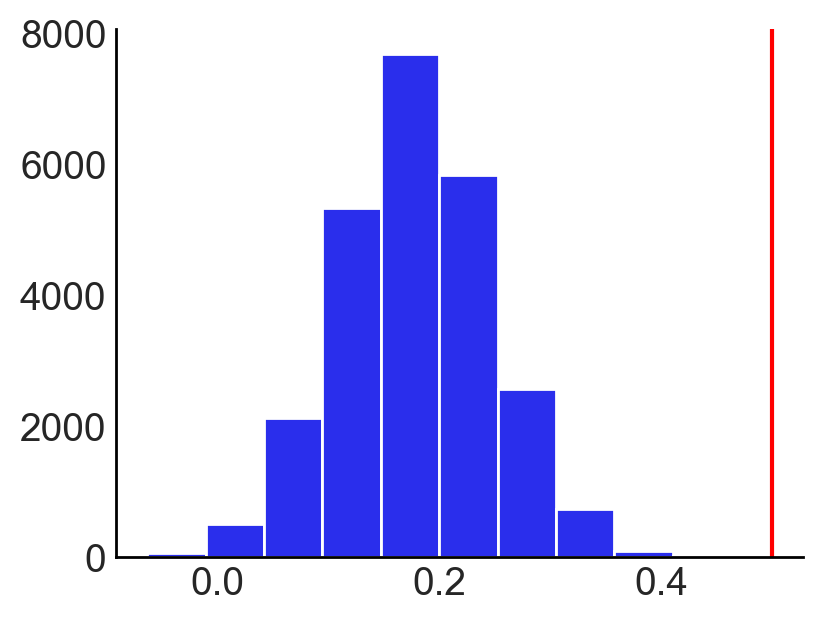

In [269]:
def q025(x):
    return x.quantile(.025)

def q975(x):
    return x.quantile(.975)

def q005(x):
    return x.quantile(.005)

def q995(x):
    return x.quantile(.995)

print(twostage_post_samp_jit.shape)
# print(twostage_post_samp)
print([f"alpha_{i} = {al}" for i, al in enumerate(alpha)], "sig:",1)
print(twostage_post_samp_jit.agg(['mean','std','median',q005,q025, q975, q995,'min','max']))

plt.figure(figsize=(4,3))
plt.hist(twostage_post_samp_jit["alpha_2"])
plt.axvline(x=0.5, color="red")
# plt.scatter(twostage_post_samp["alpha_2"],twostage_post_samp["alpha_3"])

# TODO: check what is going on in here... we obtain weird results for alpha_2

In [271]:
# Three-stage: for each A* and A|A* param, sample one A*, and sample one (or more) outcome models
def threestage_estimator(MCMC_obj, net_post_samples, Y, Z, X, n, i):

    # sample network
    curr_Astar = triu_to_mat(net_post_samples[i,], n)
    
    # Run MCMC
    MCMC_obj.run(random.PRNGKey(i),Y=Y,Z=Z,X=X,A=curr_Astar,n=n)
    curr_posterior_samples = MCMC_obj.get_samples()

    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)


def threestage_jj(triu_post_samp, Y, Z, X, i):
    # sample network
    # curr_Astar = triu_to_mat(triu_post_samp, NN)
    curr_Astar = Triu_to_mat(triu_post_samp)
    # compute stats
    expos, eigen_cen, between = compute_net_stats(curr_Astar, Z)
    # get df
    cur_df = np.transpose(np.array([[1]*NN,Z,expos,X,eigen_cen,between]))
    # Run MCMC
    curr_posterior_samples = get_samples(random.PRNGKey(i), Y, cur_df)
    # save results
    alpha_shape = curr_posterior_samples["alpha"].shape
    converted_post_samp = {"iter" : i, "sig" : curr_posterior_samples["sig"]}
    for j in range(alpha_shape[1]):
        converted_post_samp["alpha" + '_' + str(j)] = curr_posterior_samples["alpha"][:, j]
    return pd.DataFrame(converted_post_samp)
     
#      
# kernel_outcome = NUTS(outcome_model)
# # mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=250,num_chains=2, progress_bar=False)
# mcmc_network_pred = MCMC(kernel_outcome, num_warmup=1000, num_samples=100,num_chains=2, progress_bar=False)
# Astar_post_shape = post_predictive["triu_star"].shape
# i_range = np.random.randint(low=0,high=Astar_post_shape[0]-1, size = 3000)

# print("starting parallel")
# start = time.time()
# threestage_post_samp = Parallel(n_jobs=8)(delayed(threestage_estimator)(mcmc_network_pred, post_predictive["triu_star"], Y, Z,x, n,i) for i in tqdm(i_range))
# threestage_post_samp = pd.concat(threestage_post_samp,axis=0)
# print(threestage_post_samp)
# print("No JIT time: ", time.time() - start)


K = 50
i_range = np.random.choice(a = range(post_predictive["triu_star"].shape[0]), size = K, replace = False)
start = time.time()
threestage_post_samp_jit = pd.DataFrame()
for i in tqdm(i_range):
# for i in tqdm(range(Astar_post_shape[0])):
# for i in tqdm(range(Astar_post_shape[0])):
    cur_res = threestage_jj(post_predictive["triu_star"][i,], Y, Z, x, i)
    threestage_post_samp_jit = pd.concat([threestage_post_samp_jit, cur_res])    
print(threestage_post_samp_jit)
print("with JIT (non parallel) takes: ", time.time() - start)




100%|██████████| 50/50 [01:20<00:00,  1.60s/it]

      iter       sig   alpha_0   alpha_1   alpha_2   alpha_3    alpha_4  \
0    12973  1.713692 -0.756189  3.156488  0.181372 -0.243612  15.498993   
1    12973  1.443874 -0.955412  3.213460  0.205188 -0.265077  18.050640   
2    12973  1.662127 -0.795697  3.206833  0.210807 -0.273761  15.992034   
3    12973  1.502815 -0.522901  3.057927  0.121564 -0.261387  22.159611   
4    12973  1.527059 -1.172285  3.617569  0.175505 -0.233701  20.509275   
..     ...       ...       ...       ...       ...       ...        ...   
495   7365  1.578217 -0.298186  3.051971  0.111291 -0.249954  16.992561   
496   7365  1.541238 -0.456806  3.137521  0.141745 -0.279263  19.406063   
497   7365  1.573986 -0.552944  3.082714  0.131858 -0.293457  20.193558   
498   7365  1.522396 -0.021010  3.309891  0.166077 -0.278997  12.391062   
499   7365  1.524589 -0.649808  3.383963  0.201860 -0.287854  14.484976   

       alpha_5  
0     2.475878  
1   -12.590020  
2     9.267931  
3   -13.806270  
4     5.408912

(25000, 8)
['alpha_0 = -1', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25', 'alpha_4 = 5', 'alpha_5 = 5'] sig: 1
                iter       sig   alpha_0   alpha_1   alpha_2   alpha_3  \
mean     9139.660000  1.530697 -0.526099  3.159241  0.171610 -0.269564   
std      4564.674463  0.070075  0.260694  0.209635  0.081774  0.030082   
median  10485.500000  1.528560 -0.519632  3.158833  0.167012 -0.269790   
q005      811.000000  1.365414 -1.229152  2.624610 -0.022682 -0.347202   
q025      837.000000  1.400849 -1.052410  2.750945  0.021545 -0.328885   
q975    15235.000000  1.673776 -0.039105  3.571037  0.347251 -0.210362   
q995    15806.000000  1.720604  0.113722  3.704817  0.407042 -0.190895   
min       811.000000  1.292915 -1.586642  2.290524 -0.101663 -0.383493   
max     15806.000000  1.824614  0.459206  4.010497  0.524722 -0.147694   

          alpha_4    alpha_5  
mean    18.213659  -3.025379  
std      5.126137   9.870592  
median  18.240723  -3.028298  
q005     3.950785 -

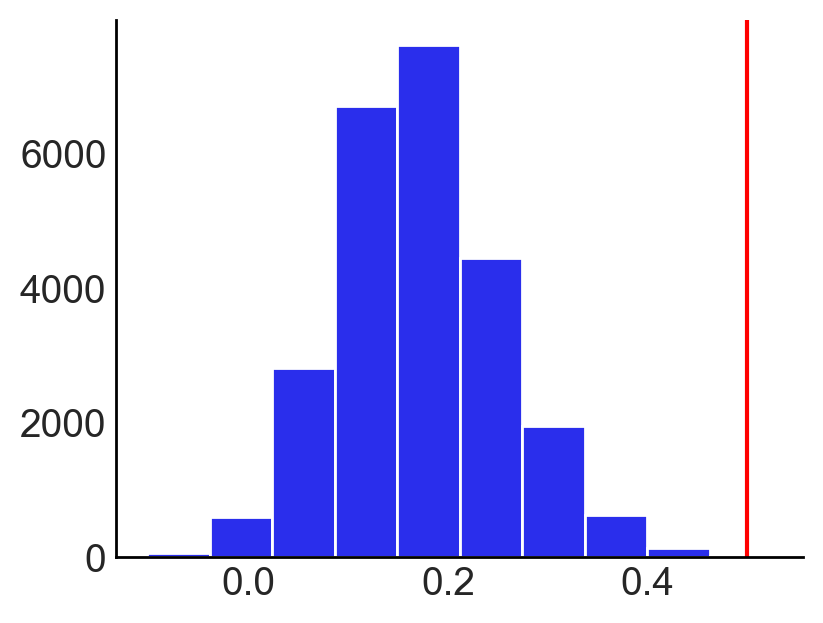

In [273]:
print(threestage_post_samp_jit.shape)
# print(threestage_post_samp)
print([f"alpha_{i} = {al}" for i, al in enumerate(alpha)], "sig:", 1)
threestage_post_samp_agg = threestage_post_samp_jit.agg(['mean','std','median',q005,q025, q975,q995,'min','max'])
print(threestage_post_samp_agg)

plt.figure(figsize=(4,3))
plt.hist(threestage_post_samp_jit["alpha_2"])
plt.axvline(x=0.5, color="red")

In [274]:
print(threestage_post_samp_agg["alpha_2"]["mean"])
dict_3S = threestage_post_samp_agg["alpha_2"].to_dict()
print(dict_3S)
dict_3S["var_MI"] = 3
print(dict_3S)
dict_3S = {k : dict_3S[k] for k in ["mean","median","var_MI","q025","q975","min","max"]}
print(pd.DataFrame(dict_3S, index = [0]))


0.17161017656326294
{'mean': 0.17161017656326294, 'std': 0.08177436143159866, 'median': 0.16701197624206543, 'q005': -0.022682161554694175, 'q025': 0.021545114926993847, 'q975': 0.34725085124373384, 'q995': 0.40704190194606804, 'min': -0.10166329145431519, 'max': 0.5247222185134888}
{'mean': 0.17161017656326294, 'std': 0.08177436143159866, 'median': 0.16701197624206543, 'q005': -0.022682161554694175, 'q025': 0.021545114926993847, 'q975': 0.34725085124373384, 'q995': 0.40704190194606804, 'min': -0.10166329145431519, 'max': 0.5247222185134888, 'var_MI': 3}
      mean    median  var_MI      q025      q975       min       max
0  0.17161  0.167012       3  0.021545  0.347251 -0.101663  0.524722


In [275]:
mean_alpha2 = np.mean(threestage_post_samp_jit["alpha_2"])

def between_var(x, mean_all):
    n_rep = len(x)
    return (1/(n_rep - 1))*np.sum(np.square(x-mean_alpha2))

alpha2_agg_by_iter = threestage_post_samp_jit[["iter","alpha_2"]].groupby("iter").agg(["mean","var"])
alpha2_agg_by_iter.columns = ["mean","var"]
alpha2_VB = between_var(alpha2_agg_by_iter["mean"], mean_alpha2)
alpha2_VW = np.mean(alpha2_agg_by_iter["var"])

alpha2_MI_var = alpha2_VB*(1 + 1/K) + alpha2_VW
print("VB: ", alpha2_VB, "VW: ", alpha2_VW, " Total var: ", alpha2_MI_var,
      " Naive var: ", np.var(threestage_post_samp_jit["alpha_2"]))



VB:  0.0036439679715098163 VW:  0.003121934  Total var:  0.006838781230759863  Naive var:  0.0066867787


In [276]:

# `cut posterior` : for each A* and A|A* param, sample one A*, and compute network statistics distribution (e.g., degrees and exposures)
# The uncertainty in A* and A|A* *doesn't* propagate into the outcome model which depends on the network statistics
# Use the mean network stat in the outcome model (i.e., only one outcome model run!).
def onestage_estimator(net_post_samples, Z, n, i_range):
    
    deg_list = []
    # sum_expos_list = []
    expos_list = []
    eig_cen_list = []
    between_list = []
    
    for i in i_range:
        # sample network
        # curr_Astar = triu_to_mat(net_post_samples[i,], n)
        curr_Astar = Triu_to_mat(net_post_samples[i,])
        # compute stat
        expos, eig_cen, between = compute_net_stats(curr_Astar, Z)
        
        # save statistics
        # c_deg = np.sum(curr_Astar,1)
        # c_sum_expos = np.dot(curr_Astar, Z)
        # c_expos = np.where(np.equal(c_deg,0),0,c_sum_expos/c_deg)
        
        deg_list.append([np.sum(curr_Astar,1)])
        # expos_list.append([np.dot(curr_Astar, Z)])
        
        expos_list.append([expos])
        eig_cen_list.append([eig_cen])
        between_list.append([between])
        
        
        # deg_list.append([c_deg])
        # sum_expos_list.append([c_sum_expos])
        # expos_list.append([c_expos])
    
    return {'deg' : deg_list,
            # 'sum_expos' : sum_expos_list,
            'expos' : expos_list,
            'eig_cen' : eig_cen_list,
            'between' : between_list}
        
# i_range = np.random.randint(low=0, high=post_predictive["triu_star"].shape[0],size =5000)
start = time.time()
onestage_net_stat = onestage_estimator(post_predictive["triu_star"], Z, n, range(post_predictive["triu_star"].shape[0]))
print(time.time() - start)
# onestage_net_stat = Parallel(n_jobs=8)(delayed(onestage_estimator)(post_predictive["triu_star"], Z, n,i) for i in tqdm(i_range))
# kernel_outcome = NUTS(outcome_model)
# mcmc_network_pred = MCMC(kernel_outcome, num_warmup=500, num_samples=1000,num_chains=1, progress_bar=False)
# Astar_post_shape = post_predictive["triu_star"].shape
# i_range = np.random.randint(low=0,high=Astar_post_shape[0]-1, size = 1000)


KeyboardInterrupt: 

deg corr 0.9049991507187599
expos corr 0.8488422778143463
expos (hat) corr Y 0.5624271911174453
expos (true) corr Y 0.6112175267930011


Text(0, 0.5, 'True expos')

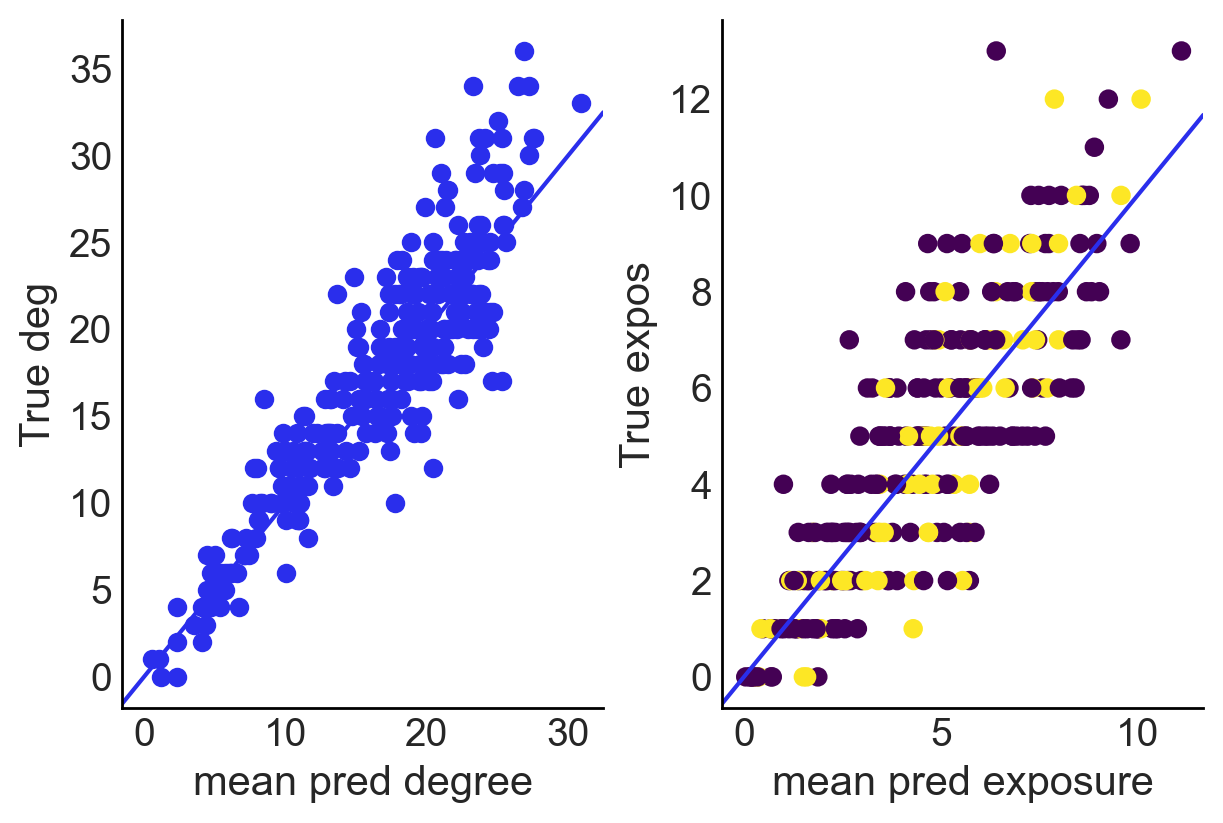

In [29]:
mean_deg = np.mean(onestage_net_stat["deg"],axis=0)
mean_expos = np.mean(onestage_net_stat["expos"],axis=0)
# mean_sum_expos = np.mean(onestage_net_stat["sum_expos"],axis=0)

print("deg corr", np.corrcoef(mean_deg,deg)[1,0])
print("expos corr", np.corrcoef(mean_expos,exposures)[1,0])
print("expos (hat) corr Y", np.corrcoef(mean_expos,Y)[1,0])
print("expos (true) corr Y", np.corrcoef(exposures,Y)[1,0])

fig, axes = plt.subplots(nrows=1,ncols=2, sharex=False, sharey=False, figsize = (6,4))
ax1, ax2 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(mean_deg, np.sum(mat,1), marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(mean_expos, exposures,c = Z+1, marker = 'o')
ax2.axline((0,0),slope=1)
ax1.set_xlabel("mean pred degree")
ax2.set_xlabel("mean pred exposure")
ax1.set_ylabel("True deg")
ax2.set_ylabel("True expos")


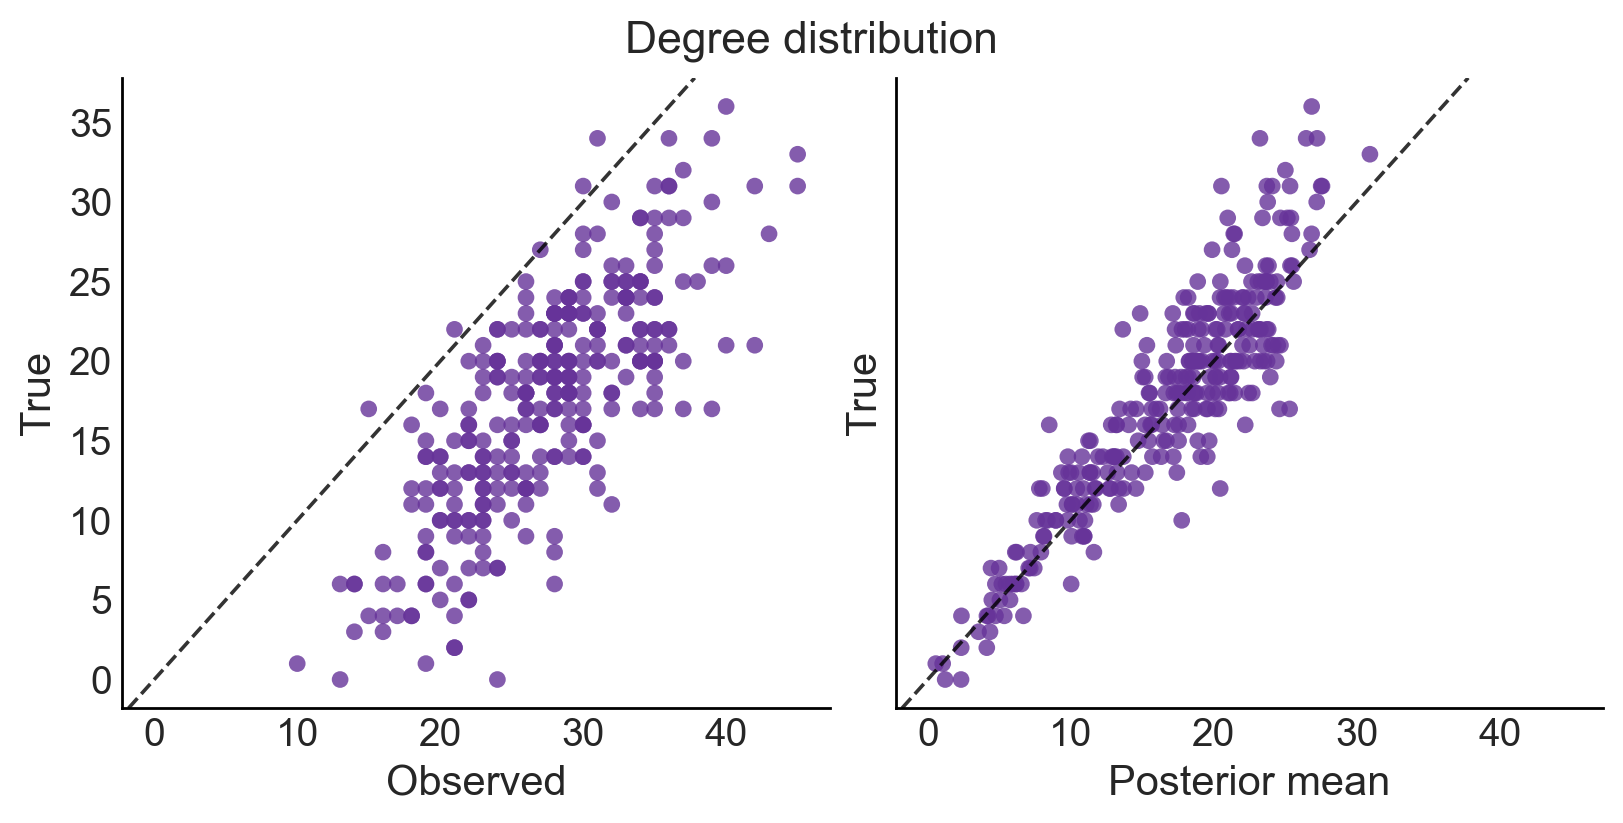

In [31]:

true_deg = np.sum(mat,1)
obs_deg = np.sum(obs_mat,1)

beige_color = '#FFFDFA'
pastel_purple_dark = (0.4, 0.2, 0.6)
# sns.set_theme(style="ticks", rc={'figure.facecolor': beige_color, 'axes.facecolor' : beige_color})
# sns.set_context("poster")


fig, axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True)
ax1, ax2 = axes.flatten()
# fig.patch.set_facecolor(beige_color)
# for ax in axes:
    # ax.set_facecolor(beige_color) 

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(x=obs_deg,y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax1.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(x=mean_deg, y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax2.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
ax2.set_xlabel("Posterior mean")
ax1.set_xlabel("Observed")
ax1.set_ylabel("True")
ax2.set_ylabel("True")

fig.suptitle('Degree distribution', fontsize=16)

fig = plt.gcf()
fig.set_size_inches(8, 4)
fig.savefig('deg_dist.png', dpi=300)

Text(0, 0.5, 'True')

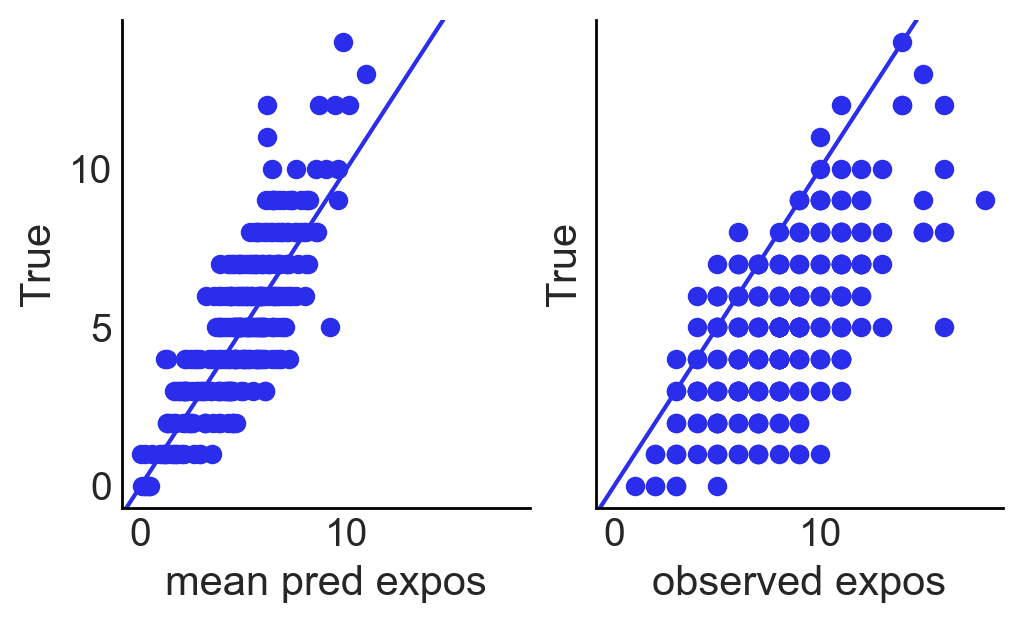

In [82]:
fig, axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True, figsize = (5,3))
ax1, ax2 = axes.flatten()

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
# ax1.scatter(mean_expos, exposures, c = Z, marker = 'o')
ax1.scatter(mean_expos, exposures, marker = 'o')
ax1.axline((0,0),slope=1)
# ax2.scatter(obs_exposures, exposures,c = Z, marker = 'o')
ax2.scatter(obs_exposures, exposures,marker = 'o')
ax2.axline((0,0),slope=1)
ax1.set_xlabel("mean pred expos")
ax2.set_xlabel("observed expos")
ax1.set_ylabel("True")
ax2.set_ylabel("True")

In [337]:
def outcome_stat_model(Y,Z,X,expos,n):
    with numpyro.plate("alpha_i",4):
        alpha = numpyro.sample("alpha",dist.Normal(0,10))
    # sig = numpyro.sample("sig",dist.HalfNormal(scale=5))
    sig = numpyro.sample("sig",dist.Exponential(0.5))
    # expos = jnp.dot(A,Z) / jnp.sum(A,1)
    # expos = (jnp.dot(A,Z) / jnp.sum(A,1)) > 0.5
    mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*X
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    with numpyro.plate("n",n):
        numpyro.sample("Y", dist.Normal(loc=mu_y,scale=sig), obs=Y)

# TODO: seems like this is the best option ATM... 
# TODO: 1. check how to represent ICAR (or CAR) models (a la spatial reg) with suffiecent statistics 


In [338]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
kernel_stat_outcome = NUTS(outcome_stat_model)
mcmc_network_stat = MCMC(kernel_stat_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
mcmc_network_stat.run(rng_key_,Y=Y,Z=Z,X=x,expos=mean_expos,n=n)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_stat.print_summary()
samples_network_stat = mcmc_network_stat.get_samples()
print(time.time() - start)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]     -1.89      0.14     -1.89     -2.12     -1.65  10287.82      1.00
  alpha[1]      3.05      0.16      3.05      2.80      3.31  13526.62      1.00
  alpha[2]      0.70      0.10      0.70      0.55      0.87  10795.87      1.00
  alpha[3]     -0.24      0.03     -0.24     -0.28     -0.20  14734.99      1.00
       sig      1.19      0.05      1.19      1.11      1.27  15103.55      1.00

Number of divergences: 0
4.517497777938843
['alpha_0 = -2', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25'] sig: 1


In [339]:
# dims = {"X": ["time"], "TriU": ["time"]}
# idata_kwargs = {"dims": dims, "constant_data": {"X": x_diff, "TriU": triu_obs}}
# trace_data = az.from_numpyro(mcmc, **idata_kwargs)
# trace_data = az.from_numpyro(posterior=mcmc_network, posterior_predictive=post_predictive,)
# display(trace_data)
# az.plot_trace(trace_data, compact=True)

In [340]:
# posterior_mu = jnp.expand_dims(samples["beta0"],-1) + jnp.expand_dims(samples["beta1"],-1)*x_diff

# print(posterior_mu.shape)
# print(posterior_mu[0:5,0:5])

# fix, ax = plt.subplots(nrows=1,ncols=1, figsize = (5,5))
# ax.plot(beta[0] + beta[1]*x_diff, posterior_mu.mean(axis=0), "o")


In [341]:
# NumPyro model
def triu_to_mat(triu, n):
    adj_mat = jnp.zeros((n,n))
    idx_triu = np.triu_indices(n=n,k=1)
    adj_mat = adj_mat.at[idx_triu].set(triu) 
    return adj_mat + adj_mat.T

def model_discrete(Y, Z, X, TriU, n):
    # Network model
    beta_0 = numpyro.sample("beta0",dist.Normal(0,10))
    beta_1 = numpyro.sample("beta1",dist.Normal(0,10))
    mu_net = beta_0 + beta_1*X 
    triu_n = int(n*(n-1)/2)
    
    gamma0 = numpyro.sample("gamma0", dist.Uniform(low=0,high=0.5))
    gamma1 = numpyro.sample("gamma1", dist.Uniform(low=0,high=0.5))
    
    # temp = numpyro.sample("temp", dist.Uniform(low=0,high=1))
    
    with numpyro.plate("A* and A",triu_n):
        # logp of A* 
        triu_star = numpyro.sample("triu_star",dist.BernoulliLogits(logits=mu_net))
        # triu_star = numpyro.sample("triu_star",dist.RelaxedBernoulliLogits(temperature=.5,logits=mu_net))
        # triu_star = numpyro.sample("triu_star",dist.RelaxedBernoulliLogits(temperature=temp,logits=mu_net))
        # # logp of A|A*
        prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*gamma0
        # prob_misspec = jnp.where(tril_star==1, 1-gamma1, gamma0)
        numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
       
    # get Astar the symmetric matrix from lower triangle values `tril_var`
    Astar = numpyro.deterministic("Astar", triu_to_mat(triu_star,n))
    # Compute exposures (Astar*Z / d)
    degrees = jnp.sum(Astar,1)
    # num_expos = jnp.dot(Astar,Z)
    # expos = numpyro.deterministic("expos", jnp.where(degress==0,0,num_expos/degrees))
    expos = numpyro.deterministic("expos", jnp.nan_to_num(jnp.dot(Astar,Z)/jnp.sum(Astar,1),nan=0.0))
       
    
    # Outcome model
    with numpyro.plate("alpha_i",4):
        alpha = numpyro.sample("alpha",dist.Normal(0,5))
    sig = numpyro.sample("sig", dist.Exponential(0.5))
    mu = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*degrees
    with numpyro.plate("n",n):
        numpyro.sample("Y",dist.Normal(mu,sig),obs=Y)
        
    
        


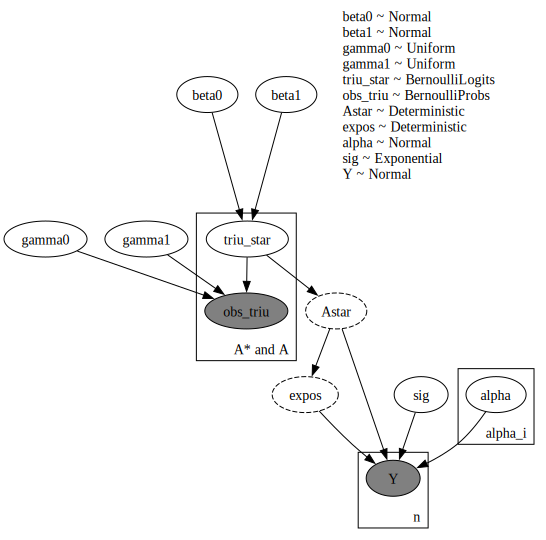

In [342]:
numpyro.render_model(model_discrete, model_args=(Y,Z,x_diff,triu_obs,n), render_distributions=True)


In [343]:
# # Sample from relaxed model
# 
# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# # kernel = DiscreteHMCGibbs(NUTS(model))
# # kernel = MixedHMC(HMC(model, trajectory_length=1.2))
# kernel = NUTS(model_relaxed)
# mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc.print_summary()
# samples = mcmc.get_samples()
# print(time.time() - start)

In [344]:
print("beta 0:", beta[0], "beta1:", beta[1], "gamma0:", gamma0, "gamma1:", gamma1)
print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)


beta 0: -2.5 beta1: -0.5 gamma0: 0.049999999999999996 gamma1: 0.3
['alpha_0 = -2', 'alpha_1 = 3', 'alpha_2 = 0.5', 'alpha_3 = -0.25'] sig: 1


In [345]:
# Sample from discrete model with mixedHMC
# 
# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# # kernel = DiscreteHMCGibbs(NUTS(model))
# kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.2), num_discrete_updates=tril_dim//6)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=1000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)

In [346]:
# Sample from discrete model with NwG

# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model_discrete))
# # kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.4), num_discrete_updates=tril_dim//4)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)

In [347]:
# Sample from discrete model with HwG

# rng_key = random.PRNGKey(0)
# rng_key, rng_key_ = random.split(rng_key)
# 
# start = time.time()
# kernel = DiscreteHMCGibbs(HMC(model_discrete))
# # kernel_d = MixedHMC(HMC(model_discrete, trajectory_length=1.4), num_discrete_updates=tril_dim//4)
# # kernel_d = MixedHMC(HMC(model_discrete))
# # kernel = NUTS(model_relaxed)
# mcmc_d = MCMC(kernel_d, num_warmup=1000, num_samples=2000,num_chains=4)
# # mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc_d.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
# mcmc_d.print_summary()
# samples_d = mcmc_d.get_samples()
# print(time.time() - start)